# 001

現実写真のみ、文字なし

In [1]:
import os
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import subprocess
if not os.path.exists("Japanese_BPEEncoder_V2"):
    subprocess.run(["git", "clone", "https://github.com/tanreinama/Japanese-BPEEncoder_V2.git", "Japanese_BPEEncoder_V2"])
from Japanese_BPEEncoder_V2.encode_swe import SWEEncoder_ja

In [15]:
EXPERIENCE_NUMBER = "001"

# PCによって変更する
NUM_WORKERS = 20
# データセットが既に存在する場合に，再度作り直すか
RESET_DATA = False
# Autoencoderを学習しなおすか
RETRAIN_AUTOENCODER = False

# 現実写真以外を使用するか
USE_UNREAL_IMAGE = False
# 文字を含む画像を使用するか
USE_WORD_IMAGE = False
# 固有名詞を含む大喜利を使用するか
USE_UNIQUE_NOUN_BOKE = False

# 大喜利の最小の星の数
MIN_STAR = 0
# 単語の最小出現回数
MIN_APPER_WORD = 32
# 大喜利の最小単語数
MIN_SENTENCE_LENGTH = 4
# 大喜利の最大単語数
MAX_SENTENCE_LENGTH = 31

RESULT_DIR = f"../../results/GUMI_AE/{EXPERIENCE_NUMBER}/"
if not os.path.exists("../../results/GUMI_AE/"):
    os.mkdir("../../results/GUMI_AE/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

# 
BATCH_SIZE_FOR_AUTOENCODER = 32
EPOCH_FOR_AUTOENCODER = 25
LEARNING_RATO_FOR_AUTOENCODER = 0.0001
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_FEATURE_DIM = 16384

BATCH_SIZE_FOR_GENERATOR = 32
EPOCH_FOR_GENERATOR = 25
LEARNING_RATO_FOR_GENERATOR = 0.0001

DATA_DIR = "../../datas/boke_data_assemble/"
IMAGE_DIR = "../../datas/boke_image/"

IMAGE_FEATURE_DIR = "../../datas/encoded/autoencoder_image_feature/"
if not os.path.exists(IMAGE_FEATURE_DIR):
    os.mkdir(IMAGE_FEATURE_DIR)

In [3]:
if not os.path.exists(f"{RESULT_DIR}test_image_paths.json") or RESET_DATA:
    image_paths = list()

    for IP in tqdm(os.listdir(IMAGE_DIR)):
        
        N = int(IP.split(".")[0])
        if not os.path.exists(f"{DATA_DIR}{N}.json"):
            continue

        with open(f"{DATA_DIR}{N}.json", "r") as f:
            a = json.load(f)
        
        image_information = a["image_information"]
        is_photographic_probability = image_information["is_photographic_probability"]
        ocr = image_information["ocr"]

        # 現実写真以外を除去
        if not USE_UNREAL_IMAGE:
            if is_photographic_probability < 0.8: continue
            
        # 文字のある画像を除去
        if not USE_WORD_IMAGE:
            if len(ocr) != 0: continue
        
        image_paths.append(f"{IMAGE_DIR}{IP}")

    train_image_paths, test_image_paths = train_test_split(image_paths, test_size = 0.1)

    with open(f"{RESULT_DIR}train_image_paths.json", "w") as f:
        json.dump(train_image_paths, f)
    with open(f"{RESULT_DIR}test_image_paths.json", "w") as f:
        json.dump(test_image_paths, f)
    
else:
    with open(f"{RESULT_DIR}train_image_paths.json", "r") as f:
        train_image_paths = json.load(f)
    with open(f"{RESULT_DIR}test_image_paths.json", "r") as f:
        test_image_paths = json.load(f)

len(train_image_paths), len(test_image_paths)

(228908, 25435)

In [4]:
# 画像の前処理
image_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
])

# 画像のデータローダを作る関数
def make_image_dataloader(image_paths, batch_size, num_workers = 4):

    class LoadImageDataset(Dataset):
        def __init__(self, image_paths):
            """
                image_paths: 画像のパスからなるリスト
            """
            self.image_paths = image_paths

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image = Image.open(image_paths[idx]).convert("RGB")

            return image, self.image_paths[idx]
    
    def collate_fn_tf(batch):
        images = torch.stack([image_preprocess(B[0]) for B in batch])
        image_numbers = [B[1] for B in batch]

        return images, image_numbers

    print(f"num data: {len(image_paths)}")

    dataset = LoadImageDataset(image_paths)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        num_workers = num_workers, 
        collate_fn = collate_fn_tf
    )

    return dataloader

In [5]:
class ImageEncoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(ImageEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)

        self.fc1 = nn.Linear(16384, 16384)
        self.fc2 = nn.Linear(16384, image_feature_dim)
    
    def forward(self, images):
        x = F.leaky_relu( self.conv1(images) )
        # 32, 64, 64
        x = F.leaky_relu( self.conv2(x) )
        # 64, 32, 32
        x = F.leaky_relu( self.conv3(x) )
        # 128, 16, 16
        x = F.leaky_relu( self.conv4(x) )
        # 256, 8, 8

        x = nn.Flatten()(x)
        x = F.leaky_relu(self.fc1(x))
        return F.leaky_relu(self.fc2(x))

class ImageDecoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(ImageDecoder, self).__init__()

        self.fc1 = nn.Linear(image_feature_dim, 16384)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv4 = nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
        self.conv1 = nn.Conv2d(32, 3, kernel_size = 3, stride = 1, padding = 1)
    
    def forward(self, image_features):
        x = F.leaky_relu(self.fc1(image_features))
        x = nn.Unflatten(1, (256, 8, 8))(x)
        # 256, 8, 8

        x = F.leaky_relu( self.deconv1(x) )
        # 128, 16, 16
        x = F.leaky_relu( self.deconv2(x) )
        # 64, 32, 32
        x = F.leaky_relu( self.deconv3(x) )
        # 32, 64, 64
        x = F.leaky_relu( self.deconv4(x) )
        # 32, 128, 128
        return nn.Sigmoid()( self.conv1(x) )
        # 3, 128, 128

ImageDecoder(IMAGE_FEATURE_DIM)(torch.zeros([1, IMAGE_FEATURE_DIM]))

class Autoencoder(nn.Module):
    def __init__(self, image_feature_dim):
        """
            image_feature_dim: 
        """
        super(Autoencoder, self).__init__()

        self.encoder = ImageEncoder(image_feature_dim)
        self.decoder = ImageDecoder(image_feature_dim)
    
    def forward(self, images):
        return self.decoder( self.encoder(images) )

In [6]:
def predict_by_autoencoder(autoeuncoder, image_paths, device = "cuda"):
    tmp_images = [image_preprocess(Image.open(IP)) for IP in image_paths]
    images = torch.stack(tmp_images).to(device)

    predict_images = autoencoder(images).permute(0, 2, 3, 1).cpu().detach().numpy()

    fig = plt.figure()
    for i in range(len(image_paths)):
        ax = fig.add_subplot(2, len(image_paths), i + 1)
        ax.imshow(tmp_images[i].permute(1, 2, 0))
        ax.axis("off")
        ax.set_title("input")

        ax = fig.add_subplot(2, len(image_paths), len(image_paths) + i + 1)
        ax.imshow(predict_images[i])
        ax.axis("off")
        ax.set_title("predict")
    plt.show()

In [7]:
if not os.path.exists(f"{RESULT_DIR}autoencoder_history.png") or RETRAIN_AUTOENCODER:
    train_loss_history = []
    test_loss_history = []

    device = "cuda" if torch.cuda.is_available() else "cpu"
    autoencoder = Autoencoder(image_feature_dim = IMAGE_FEATURE_DIM)
    autoencoder.to(device)
    optimizer = optim.AdamW(autoencoder.parameters(), lr = LEARNING_RATO_FOR_AUTOENCODER)

    train_image_dataloader = make_image_dataloader(train_image_paths, batch_size = BATCH_SIZE_FOR_AUTOENCODER, num_workers = NUM_WORKERS)
    test_image_dataloader = make_image_dataloader(test_image_paths, batch_size = BATCH_SIZE_FOR_AUTOENCODER, num_workers = NUM_WORKERS)

    # 1イテレーション学習する関数
    def train_step_for_autoencoder(autoencoder, optimizer, images):
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = nn.MSELoss()(outputs, images)
        loss.backward()
        optimizer.step()
        return loss.item()

    # 1イテレーション検証する関数
    def test_step_for_autoencoder(model, images):
        with torch.no_grad():
            outputs = autoencoder(images)
            loss = nn.MSELoss()(outputs, images)
        return loss.item()

    for epoch in range(EPOCH_FOR_AUTOENCODER):

        # train
        train_loss_obj = 0.0
        autoencoder.train()
        pb = tqdm(train_image_dataloader, desc = f"Epoch {epoch+1}/{EPOCH_FOR_AUTOENCODER}")
        
        for images, _ in pb:
            images = images.float().to("cuda")

            loss = train_step_for_autoencoder(autoencoder, optimizer, images)
            train_loss_obj += loss
            pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1),})
        train_loss = train_loss_obj / len(train_image_dataloader)

        # test
        test_loss_obj = 0.0
        autoencoder.eval()
        pb = tqdm(test_image_dataloader, desc = f"Epoch {epoch+1}/{EPOCH_FOR_AUTOENCODER}")
        
        for images, _ in pb:
            images = images.to(device)

            loss = test_step_for_autoencoder(autoencoder, images)
            test_loss_obj += loss
            pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1),})
        test_loss = test_loss_obj / len(test_image_dataloader)

        print(f"Epoch: {epoch+1}/{EPOCH_FOR_AUTOENCODER}, "
            f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print("-" * 25)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        # 検証誤差を更新した場合、重みを保存
        if min(test_loss_history) == test_loss:
            torch.save(autoencoder.state_dict(), f"{RESULT_DIR}best_autoencoder_weights.pth")

        predict_by_autoencoder(autoencoder, test_image_paths[:5])

    # 学習結果を保存
    with open(f"{RESULT_DIR}autoencoder_history.json", "w") as f:
        json.dump({
            "train_loss": train_loss_history,
            "test_loss": test_loss_history,
        }, f)

    # 学習結果を描画
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_loss_history, label = "train")
    ax.plot(test_loss_history, label = "test")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend()
    ax.grid()

    fig.savefig(f"{RESULT_DIR}autoencoder_history.png")

In [8]:
# データセットの作成
if not os.path.exists(f"{RESULT_DIR}index_to_word.json") or RESET_DATA:
    # tokenizer
    with open('Japanese_BPEEncoder_V2/ja-swe32kfix.txt') as f:
        bpe = f.read().split('\n')

    with open('Japanese_BPEEncoder_V2/emoji.json') as f:
        emoji = json.loads(f.read())

    tokenizer = SWEEncoder_ja(bpe, emoji)

    tmp = list()
    word_count_dict = dict()

    for JP in tqdm(os.listdir(DATA_DIR)):
        
        N = int(JP.split(".")[0])

        with open(f"{DATA_DIR}{JP}", "r") as f:
            a = json.load(f)
        
        image_information = a["image_information"]
        is_photographic_probability = image_information["is_photographic_probability"]
        ocr = image_information["ocr"]

        # 現実写真以外を除去
        if not USE_UNREAL_IMAGE:
            if is_photographic_probability < 0.8: continue
            
        # 文字のある画像を除去
        if not USE_WORD_IMAGE:
            if len(ocr) != 0: continue
        
        bokes = a["bokes"]

        for B in bokes:
            # 星が既定の数以下の大喜利を除去
            if B["star"] < MIN_STAR:
                continue

            # 固有名詞を含む大喜利を除去
            if not USE_UNIQUE_NOUN_BOKE:
                if len(B["unique_nouns"]) != 0: continue

            tokenized_boke = tokenizer.encode(B["boke"])
            # 単語数が既定の数でない大喜利を除去
            if not MIN_SENTENCE_LENGTH <= len(tokenized_boke) < MAX_SENTENCE_LENGTH:
                continue

            for W in tokenized_boke:
                try:
                    word_count_dict[W] += 1
                except:
                    word_count_dict[W] = 1
            
            tmp.append({
                "image_number": N,
                "tokenized_boke": tokenized_boke
            })

    # 単語の最小出現回数を満たさない大喜利を除去
    boke_datas = list()
    words = list()

    for D in tqdm(tmp):
        flag = False
        for W in D["tokenized_boke"]:
            if word_count_dict[W] < MIN_APPER_WORD:
                flag = True
                break
        if flag: 
            continue
        
        boke_datas.append({
            "image_number": D["image_number"],
            "tokenized_boke": D["tokenized_boke"]
        })
        words += D["tokenized_boke"]
    words = set(words)
    image_numbers = list(set([D["image_number"] for D in boke_datas]))
    del tmp

    # tokenize
    index_to_index = dict()

    c = 3
    for D in tqdm(boke_datas):
        tmp = list()
        for W in D["tokenized_boke"]:
            try:
                index_to_index[W]
            except:
                index_to_index[W] = c
                c += 1
            tmp.append(index_to_index[W])
        D["tokenized_boke"] = [1] + tmp + [2]

    index_to_word = {
        V: tokenizer.decode([K]) for K, V in index_to_index.items()
    }
    index_to_word[0] = "<PAD>"
    index_to_word[1] = "<START>"
    index_to_word[2] = "<END>"

    #
    train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)

    with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
        json.dump(train_boke_datas, f)
    with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
        json.dump(test_boke_datas, f)
    with open(f"{RESULT_DIR}index_to_word.json", "w") as f:
        json.dump(index_to_word, f)

else:
    with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
        train_boke_datas = json.load(f)
    with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
        test_boke_datas = json.load(f)
    with open(f"{RESULT_DIR}index_to_word.json", "r") as f:
        index_to_word = json.load(f)

    image_numbers = [D["image_number"] for D in train_boke_datas] + [D["image_number"] for D in test_boke_datas]
    image_numbers = list(set(image_numbers))

print(f"学習に用いる大喜利の数: {len(train_boke_datas)}\n", 
      f"検証に用いる大喜利の数: {len(test_boke_datas)}\n",
      f"使用する画像の数: {len(image_numbers)}\n",
      f"単語の種類: {len(index_to_word)}")

学習に用いる大喜利の数: 2030920
 検証に用いる大喜利の数: 20515
 使用する画像の数: 244286
 単語の種類: 16705


In [10]:
# 画像を特徴量に変換する
if RETRAIN_AUTOENCODER:
    shutil.rmtree(IMAGE_FEATURE_DIR) 
    os.mkdir(IMAGE_FEATURE_DIR)

tmp = list()
for IN in tqdm(image_numbers):
    if os.path.exists(f"{IMAGE_FEATURE_DIR}{IN}.npy"):
        continue
    tmp.append(f"{IMAGE_DIR}{IN}.jpg")

if len(tmp) != 0:
    image_dataloader = make_image_dataloader(tmp, batch_size = 128, num_workers = NUM_WORKERS)

    # encoder of Autoencoder
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder = Autoencoder(image_feature_dim = IMAGE_FEATURE_DIM)
    autoencoder.load_state_dict(torch.load(f"{RESULT_DIR}best_autoencoder_weights.pth"))
    model = autoencoder.encoder
    model = model.to(device)
    model.eval()

    for Is, IPs in tqdm(image_dataloader):
        Is = Is.to(device)
        features = model(Is).detach().cpu().numpy()

        for f, IP in zip(features, IPs):
            N = IP.split("/")[-1].split(".")[0]
            np.save(f"{IMAGE_FEATURE_DIR}{N}", f)

100%|██████████| 244286/244286 [00:00<00:00, 819390.20it/s]


num data: 244285


<ipython-input-10-ec220e3680c9>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(f"{RESULT_DIR}best_autoencoder_weights.pth"))
100%|█

In [11]:
# 大喜利生成モデルのクラス
class BokeGeneratorModel(nn.Module):
    def __init__(self, num_word, image_feature_dim, sentence_length, embedding_dim = 512):
        """
            num_word: 学習に用いる単語の総数
            image_feature_dim: 画像の特徴量の次元数
            sentence_length: 入力する文章の単語数
            embedding_dim: 単語の埋め込み次元数
        """
        super(BokeGeneratorModel, self).__init__()
        self.num_word = num_word
        self.image_feature_dim = image_feature_dim
        self.sentence_length = sentence_length
        self.embedding_dim = embedding_dim
        
        self.fc1 = nn.Linear(image_feature_dim, embedding_dim)
        self.embedding = nn.Embedding(num_word, embedding_dim, padding_idx = 0)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = embedding_dim, 
                            batch_first = True)
        self.fc2 = nn.Linear(embedding_dim + embedding_dim, 2 * embedding_dim)
        self.fc3 = nn.Linear(2 * embedding_dim, 2 * embedding_dim)
        self.fc4 = nn.Linear(2 * embedding_dim, num_word)
    
    # LSTMの初期値は0で，画像の特徴量と文章の特徴量を全結合層の前で結合する
    def forward(self, image_features, sentences):
        """
            image_features: 画像の特徴量
            sentences: 入力する文章
        """
        x1 = F.leaky_relu(self.fc1(image_features))
        x1 = x1.unsqueeze(1).repeat(1, self.sentence_length, 1)

        x2 = self.embedding(sentences)
        x2, _ = self.lstm(x2)

        x = torch.cat((x1, x2), dim = -1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        return self.fc4(x)

In [14]:
# 大喜利生成AIの学習用データローダを作る関数
def make_dataloader(boke_datas, max_sentence_length, batch_size, num_workers = 4):
    """
        boke_datas: {"image_number":画像のお題番号 ,"tokenized_boke":トークナイズされた大喜利}からなるリスト
        max_sentence_length: 学習データの最大単語数(<START>, <END>トークンを含まない)
        num_workers: データローダが使用するCPUのスレッド数
    """
    class SentenceGeneratorDataset(Dataset):
        def __init__(self, image_file_numbers, sentences, teacher_signals):
            """
                image_file_numbers: 画像の番号からなるリスト
                sentences: 入力文章からなるリスト
                teacher_signals: 教師信号からなるリスト
            """
            if len(image_file_numbers) != len(sentences) and len(teacher_signals) != len(sentences):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_numbers = image_file_numbers
            self.sentences = sentences
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            image_feature = np.load(f"{IMAGE_FEATURE_DIR}{self.image_file_numbers[idx]}.npy")
            sentence = self.sentences[idx]
            teacher_signal = self.teacher_signals[idx]

            return image_feature, sentence, teacher_signal

    def collate_fn_tf(batch):
        image_features = torch.tensor(np.array([B[0] for B in batch]))
        sentences = torch.tensor(np.array([B[1] for B in batch]))
        teacher_signals = torch.tensor(np.array([B[2] for B in batch]))

        return image_features, sentences, teacher_signals

    image_file_numbers = list()
    sentences = list()
    teacher_signals = list()

    for D in tqdm(boke_datas):
        image_file_numbers.append(D["image_number"])
        tmp = D["tokenized_boke"] + [0] * (2 + max_sentence_length - len(D["tokenized_boke"]))
        sentences.append(tmp[:-1])
        teacher_signals.append(tmp[1:])

    dataset = SentenceGeneratorDataset(image_file_numbers, sentences, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        num_workers = num_workers, 
        collate_fn = collate_fn_tf
    )

    print(f"num data: {len(teacher_signals)}")

    return dataloader

In [16]:
train_dataloader = make_dataloader(train_boke_datas, max_sentence_length = MAX_SENTENCE_LENGTH, batch_size = BATCH_SIZE_FOR_GENERATOR, num_workers = NUM_WORKERS)
test_dataloader = make_dataloader(test_boke_datas, max_sentence_length = MAX_SENTENCE_LENGTH, batch_size = BATCH_SIZE_FOR_GENERATOR, num_workers = NUM_WORKERS)

# モデルの学習
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BokeGeneratorModel(num_word = len(index_to_word), 
                           image_feature_dim = IMAGE_FEATURE_DIM, 
                           sentence_length = MAX_SENTENCE_LENGTH + 1, 
                           embedding_dim = 2048)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATO_FOR_GENERATOR)

100%|██████████| 2030920/2030920 [00:04<00:00, 485735.64it/s] 


num data: 2030920


100%|██████████| 20515/20515 [00:00<00:00, 1101503.47it/s]


num data: 20515


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.79it/s, test_loss=4.04, test_accuracy=0.331]


Epoch: 1/25, Train Loss: 4.3109, Train Accuracy: 0.3024, Test Loss: 4.0182, Test Accuracy: 0.3294
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.66it/s, test_loss=4.02, test_accuracy=0.341]


Epoch: 2/25, Train Loss: 3.9134, Train Accuracy: 0.3426, Test Loss: 3.9901, Test Accuracy: 0.3387
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.98it/s, test_loss=4.03, test_accuracy=0.343]


Epoch: 3/25, Train Loss: 3.7687, Train Accuracy: 0.3554, Test Loss: 3.9988, Test Accuracy: 0.3400
-------------------------


Evaluating: 100%|██████████| 642/642 [00:09<00:00, 64.21it/s, test_loss=4.06, test_accuracy=0.339]


Epoch: 4/25, Train Loss: 3.6638, Train Accuracy: 0.3653, Test Loss: 4.0424, Test Accuracy: 0.3377
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.61it/s, test_loss=4.09, test_accuracy=0.335]


Epoch: 5/25, Train Loss: 3.5691, Train Accuracy: 0.3745, Test Loss: 4.0826, Test Accuracy: 0.3345
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.84it/s, test_loss=4.15, test_accuracy=0.334]


Epoch: 6/25, Train Loss: 3.4903, Train Accuracy: 0.3826, Test Loss: 4.1418, Test Accuracy: 0.3329
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.91it/s, test_loss=4.24, test_accuracy=0.332]


Epoch: 7/25, Train Loss: 3.4242, Train Accuracy: 0.3899, Test Loss: 4.2204, Test Accuracy: 0.3301
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.98it/s, test_loss=4.32, test_accuracy=0.331]


Epoch: 8/25, Train Loss: 3.3655, Train Accuracy: 0.3964, Test Loss: 4.2949, Test Accuracy: 0.3297
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 64.04it/s, test_loss=4.37, test_accuracy=0.327]


Epoch: 9/25, Train Loss: 3.3148, Train Accuracy: 0.4023, Test Loss: 4.3549, Test Accuracy: 0.3263
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.33it/s, test_loss=4.47, test_accuracy=0.327]


Epoch: 10/25, Train Loss: 3.2717, Train Accuracy: 0.4076, Test Loss: 4.4318, Test Accuracy: 0.3244
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.63it/s, test_loss=4.51, test_accuracy=0.322]


Epoch: 11/25, Train Loss: 3.2316, Train Accuracy: 0.4126, Test Loss: 4.5028, Test Accuracy: 0.3214
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.52it/s, test_loss=4.59, test_accuracy=0.323]


Epoch: 12/25, Train Loss: 3.1959, Train Accuracy: 0.4172, Test Loss: 4.5637, Test Accuracy: 0.3215
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.72it/s, test_loss=4.63, test_accuracy=0.321]


Epoch: 13/25, Train Loss: 3.1661, Train Accuracy: 0.4212, Test Loss: 4.6092, Test Accuracy: 0.3196
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.80it/s, test_loss=4.71, test_accuracy=0.321]


Epoch: 14/25, Train Loss: 3.1405, Train Accuracy: 0.4247, Test Loss: 4.6930, Test Accuracy: 0.3201
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.42it/s, test_loss=4.75, test_accuracy=0.32] 


Epoch: 15/25, Train Loss: 3.1134, Train Accuracy: 0.4282, Test Loss: 4.7249, Test Accuracy: 0.3190
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.44it/s, test_loss=4.81, test_accuracy=0.317]


Epoch: 16/25, Train Loss: 3.0926, Train Accuracy: 0.4311, Test Loss: 4.7834, Test Accuracy: 0.3156
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.06it/s, test_loss=4.85, test_accuracy=0.317]


Epoch: 17/25, Train Loss: 3.0779, Train Accuracy: 0.4336, Test Loss: 4.8160, Test Accuracy: 0.3142
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.43it/s, test_loss=4.96, test_accuracy=0.32] 


Epoch: 18/25, Train Loss: 3.0620, Train Accuracy: 0.4360, Test Loss: 4.9040, Test Accuracy: 0.3169
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.16it/s, test_loss=5.12, test_accuracy=0.323]


Epoch: 19/25, Train Loss: 3.0467, Train Accuracy: 0.4381, Test Loss: 5.0753, Test Accuracy: 0.3204
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.24it/s, test_loss=5.09, test_accuracy=0.321]


Epoch: 20/25, Train Loss: 3.0329, Train Accuracy: 0.4400, Test Loss: 5.0535, Test Accuracy: 0.3193
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.15it/s, test_loss=4.98, test_accuracy=0.311]


Epoch: 21/25, Train Loss: 3.0313, Train Accuracy: 0.4416, Test Loss: 4.9360, Test Accuracy: 0.3081
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 62.97it/s, test_loss=4.99, test_accuracy=0.307]


Epoch: 22/25, Train Loss: 3.0153, Train Accuracy: 0.4431, Test Loss: 4.9566, Test Accuracy: 0.3051
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.45it/s, test_loss=5.03, test_accuracy=0.312]


Epoch: 23/25, Train Loss: 3.0058, Train Accuracy: 0.4445, Test Loss: 5.0097, Test Accuracy: 0.3110
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.63it/s, test_loss=5.15, test_accuracy=0.318]


Epoch: 24/25, Train Loss: 3.0009, Train Accuracy: 0.4456, Test Loss: 5.1278, Test Accuracy: 0.3164
-------------------------


Evaluating: 100%|██████████| 642/642 [00:10<00:00, 63.43it/s, test_loss=5.28, test_accuracy=0.318]


Epoch: 25/25, Train Loss: 2.9941, Train Accuracy: 0.4466, Test Loss: 5.2726, Test Accuracy: 0.3174
-------------------------


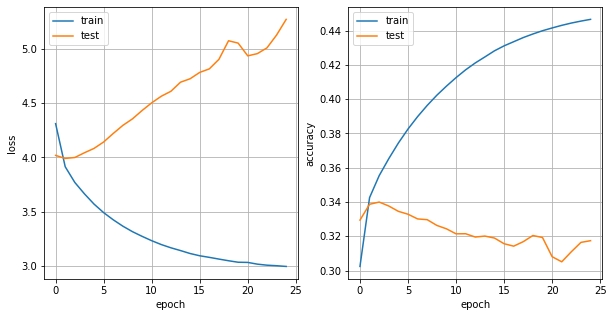

In [18]:
# 文章生成の精度を計算する関数
def calculate_accuracy(teacher_signals, outputs):
    """
        teacher_signals: 教師信号
        outputs: モデルの出力
    """
    _, predicted_words = outputs.max(dim = -1)
    # パディングに対して精度を計算しない
    mask = (teacher_signals != 0)
    correct = ((predicted_words == teacher_signals) & mask).sum().item()
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0.0
    return accuracy

# 1イテレーション学習する関数
def train_step(model, optimizer, batch_data, batch_labels):
    optimizer.zero_grad()
    outputs = model(*batch_data)
    # パディングに対して損失を計算しない
    loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), batch_labels.view(-1),
                           ignore_index = 0)
    accuracy = calculate_accuracy(batch_labels, F.softmax(outputs, dim = -1))
    loss.backward()
    optimizer.step()
    return loss.item(), accuracy

# 1イテレーション検証する関数
def evaluate(model, batch_data, batch_labels):
    with torch.no_grad():
        outputs = model(*batch_data)
        loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), batch_labels.view(-1),
                               ignore_index = 0)
        accuracy = calculate_accuracy(batch_labels, F.softmax(outputs, dim = -1))
    return loss.item(), accuracy

for epoch in range(EPOCH_FOR_GENERATOR):

    # train
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH_FOR_GENERATOR}")
    
    for image_features, sentences, teacher_signals in pb:
        image_features = image_features.to(device)
        sentences = sentences.to(device)
        teacher_signals = teacher_signals.to(device)
        
        loss, accuracy = train_step(model, optimizer, (image_features, sentences), teacher_signals)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})

    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # test
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for image_features, sentences, teacher_signals in pb:
        image_features = image_features.to(device)
        sentences = sentences.to(device)
        teacher_signals = teacher_signals.to(device)

        loss, accuracy = evaluate(model, (image_features, sentences), teacher_signals)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})

    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    print(f"Epoch: {epoch+1}/{EPOCH_FOR_GENERATOR}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("-" * 25)

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    # 学習精度を更新した場合、重みを保存
    if max(train_accuracy_history) == train_accuracy:
        torch.save(model.state_dict(), f"{RESULT_DIR}best_model_weights.pth")

# 学習結果を保存
with open(f"{RESULT_DIR}history.json", "w") as f:
    json.dump({
        "train_loss": train_loss_history,
        "train_accuracy": train_accuracy_history,
        "test_loss": test_loss_history,
        "test_accuracy": test_accuracy_history
    }, f)

# 学習結果を描画
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()

fig.savefig(f"{RESULT_DIR}history.png")